### PETR6397 Final Project: Oil Production Forecasting using Machine Learning

In [5]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

# Load the two data files from dataset folder into one dataframe df

# read the first CSV file into a DataFrame
df1 = pd.read_csv('Data/MonthlyProduction1.CSV')

# read the second CSV file into another DataFrame
df2 = pd.read_csv('Data/MonthlyProduction2.CSV')

# concatenate the two DataFrames vertically
df = pd.concat([df1, df2], axis=0)

# print the resulting DataFrame
df.head(10)

,Entity ID,API/UWI,API/UWI List,Monthly Production Date,Monthly Oil,Monthly Gas,Monthly Water,Well Count,Days,Daily Avg Oil,Daily Avg Gas,Daily Avg Water,Reservoir,Well/Lease Name,Well Number,Operator Company Name,Production Type,Production Status,Entity Type,Producing Month Number
0,130854587,4.213538e+13,4213538451,2019-12-01,1.0,139.0,7,1,NaN,0.03,4.48,0.23,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,1
1,130854587,4.213538e+13,4213538451,2020-01-01,22.0,270.0,1205,1,NaN,0.71,8.71,38.87,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,2
2,130854587,4.213538e+13,4213538451,2020-02-01,15.0,130.0,846,1,NaN,0.52,4.48,29.17,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,3
3,130854587,4.213538e+13,4213538451,2020-03-01,14.0,308.0,788,1,NaN,0.45,9.94,25.42,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,4
4,130854587,4.213538e+13,4213538451,2020-04-01,13.0,268.0,773,1,NaN,0.43,8.93,25.77,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,5
5,130854587,4.213538e+13,4213538451,2020-05-01,9.0,31.0,546,1,NaN,0.29,1.00,17.61,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,6
6,130854587,4.213538e+13,4213538451,2020-06-01,6.0,0.0,395,1,NaN,0.20,0.00,13.17,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,7
7,130854587,4.213538e+13,4213538451,2020-07-01,6.0,244.0,435,1,NaN,0.19,7.87,14.03,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,8
8,130854587,4.213538e+13,4213538451,2020-08-01,12.0,262.0,832,1,NaN,0.39,8.45,26.84,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,9
9,130854587,4.213538e+13,4213538451,2020-09-01,10.0,188.0,698,1,NaN,0.33,6.27,23.27,CLEAR FORK,SCIMITAR,1,OCCIDENTAL PETROLEUM,OIL,ACTIVE,COM,10


In [6]:
# check the shape of the DataFrame

print("Shape of the DataFrame:", df.shape)

Shape of the DataFrame: (773296, 20)


In [7]:
# check the data types of the columns

print("\n Data types of columns:\n")
df.dtypes


 Data types of columns:



Entity ID                    int64
API/UWI                    float64
API/UWI List                object
Monthly Production Date     object
Monthly Oil                float64
Monthly Gas                float64
Monthly Water                int64
Well Count                   int64
Days                       float64
Daily Avg Oil              float64
Daily Avg Gas              float64
Daily Avg Water            float64
Reservoir                   object
Well/Lease Name             object
Well Number                 object
Operator Company Name       object
Production Type             object
Production Status           object
Entity Type                 object
Producing Month Number       int64
dtype: object

In [8]:
# convert the 'Monthly Production Date' column to datetime dtype

df['Monthly Production Date'] = pd.to_datetime(df['Monthly Production Date'])
df.dtypes

Entity ID                           int64
API/UWI                           float64
API/UWI List                       object
Monthly Production Date    datetime64[ns]
Monthly Oil                       float64
Monthly Gas                       float64
Monthly Water                       int64
Well Count                          int64
Days                              float64
Daily Avg Oil                     float64
Daily Avg Gas                     float64
Daily Avg Water                   float64
Reservoir                          object
Well/Lease Name                    object
Well Number                        object
Operator Company Name              object
Production Type                    object
Production Status                  object
Entity Type                        object
Producing Month Number              int64
dtype: object

In [9]:
# check for missing values

print("\n Number of missing values:")
df.isna().sum()


 Number of missing values:


Entity ID                       0
API/UWI                         0
API/UWI List                    0
Monthly Production Date         0
Monthly Oil                   380
Monthly Gas                   356
Monthly Water                   0
Well Count                      0
Days                       746292
Daily Avg Oil                 380
Daily Avg Gas                 356
Daily Avg Water                 0
Reservoir                    2684
Well/Lease Name                 0
Well Number                  6866
Operator Company Name           0
Production Type                 0
Production Status               0
Entity Type                     0
Producing Month Number          0
dtype: int64

As we have only 27,004 values in 'Days' column out of total 7,73,296 rows. The imputation method will not be a good choice to handle this missing value issues as it will add bias in the dataset. Thus, we can drop the 'Days' column to get better efficiency.

In [10]:
# drop the 'Days' and 'Well Number' columns

df = df.drop(columns=['Days', 'Well Number'])
df.isna().sum()

Entity ID                     0
API/UWI                       0
API/UWI List                  0
Monthly Production Date       0
Monthly Oil                 380
Monthly Gas                 356
Monthly Water                 0
Well Count                    0
Daily Avg Oil               380
Daily Avg Gas               356
Daily Avg Water               0
Reservoir                  2684
Well/Lease Name               0
Operator Company Name         0
Production Type               0
Production Status             0
Entity Type                   0
Producing Month Number        0
dtype: int64

In [11]:
# summary statistics for numerical columns

df.describe()

,Entity ID,API/UWI,Monthly Oil,Monthly Gas,Monthly Water,Well Count,Daily Avg Oil,Daily Avg Gas,Daily Avg Water,Producing Month Number
count,7.732960e+05,7.732960e+05,772916.000000,772940.000000,7.732960e+05,773296.000000,772916.000000,772940.000000,773296.000000,773296.000000
mean,1.262313e+08,4.213525e+13,536.239141,546.452097,7.396827e+03,1.020856,17.616824,17.949356,243.004030,257.563919
std,1.323235e+07,1.675612e+08,1102.827386,2890.248581,1.860082e+04,0.271829,36.216032,94.893978,611.029891,194.551139
min,3.043260e+05,4.213500e+13,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.273338e+08,4.213508e+13,91.000000,15.000000,6.180000e+02,1.000000,2.970000,0.480000,20.300000,95.000000
50%,1.275302e+08,4.213530e+13,229.000000,68.000000,2.978000e+03,1.000000,7.540000,2.230000,97.810000,214.000000
75%,1.277265e+08,4.213538e+13,560.000000,283.000000,7.416000e+03,1.000000,18.390000,9.320000,243.275000,389.000000
max,1.310139e+08,4.213590e+13,35382.000000,190132.000000,1.411641e+06,9.000000,1141.350000,6133.290000,45536.810000,997.000000


As we can see their is large variation between mean and median values for Monthly oil production i.e Mean = 536.23 & Median = 229. Replace the missing value with the median of the non-missing values in the missing column will be optmal imputation method. As, this method is more robust to outliers than mean imputation and is appropriate for the data i.e. skewed or contain outliers. Thus, will impute for Monthly Oil, Monthly Gas, Daily Avg Oil & Daily Avg Gas and will use mode to impute missing values in Reservoir column.

In [12]:
# Imputation for missing values

# A) impute missing values with median for numerical columns i.e. 'Monthly Oil', 'Monthly Gas', 'Daily Avg Oil', 'Daily Avg Gas'
num_cols = ['Monthly Oil', 'Monthly Gas', 'Daily Avg Oil', 'Daily Avg Gas']
for col in num_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)


# B) Now lets impute object feature 'Reservoir' with mode
df['Reservoir'].fillna(df['Reservoir'].mode()[0], inplace=True)

df.isna().sum()

Entity ID                  0
API/UWI                    0
API/UWI List               0
Monthly Production Date    0
Monthly Oil                0
Monthly Gas                0
Monthly Water              0
Well Count                 0
Daily Avg Oil              0
Daily Avg Gas              0
Daily Avg Water            0
Reservoir                  0
Well/Lease Name            0
Operator Company Name      0
Production Type            0
Production Status          0
Entity Type                0
Producing Month Number     0
dtype: int64

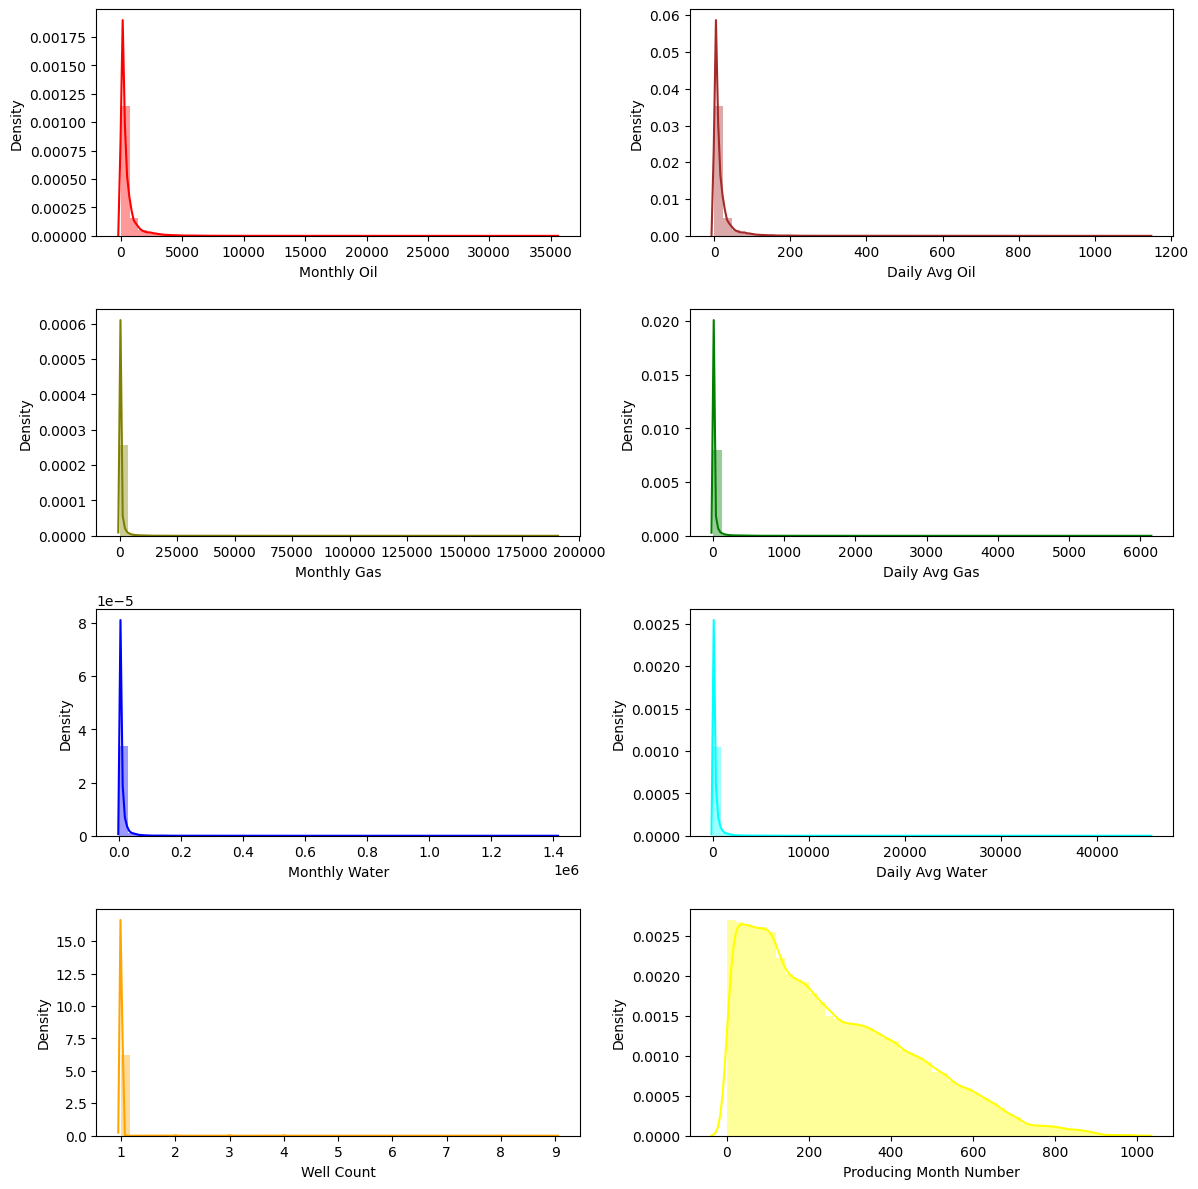

In [13]:
#let’s visualize the distribution of each parameter

f, axes = plt.subplots(4, 2, figsize=(12, 12))
sns.distplot(df['Monthly Oil'] , color="red", ax=axes[0, 0])
sns.distplot(df['Daily Avg Oil'] , color="brown", ax=axes[0, 1])
sns.distplot(df['Monthly Gas'] , color="olive", ax=axes[1, 0])
sns.distplot(df['Daily Avg Gas'] , color="green", ax=axes[1, 1])
sns.distplot(df['Monthly Water'] , color="blue", ax=axes[2, 0])
sns.distplot(df['Daily Avg Water'] , color="cyan", ax=axes[2, 1])
sns.distplot(df['Well Count'] , color="orange", ax=axes[3, 0])
sns.distplot(df['Producing Month Number'] , color="yellow", ax=axes[3, 1])

plt.tight_layout()

In [ ]:
"""

To create this boxplot its taking more than 40min to run, Ignore it or check for alternative method to visualize outliers.

#let’s visualize the Outliers for each parameter

f, axes = plt.subplots(4, 2, figsize=(12, 12))
sns.boxplot(df['Monthly Oil'] , color="red", ax=axes[0, 0])
sns.boxplot(df['Daily Avg Oil'] , color="brown", ax=axes[0, 1])
sns.boxplot(df['Monthly Gas'] , color="olive", ax=axes[1, 0])
sns.boxplot(df['Daily Avg Gas'] , color="green", ax=axes[1, 1])
sns.boxplot(df['Monthly Water'] , color="blue", ax=axes[2, 0])
sns.boxplot(df['Daily Avg Water'] , color="cyan", ax=axes[2, 1])
sns.boxplot(df['Well Count'] , color="orange", ax=axes[3, 0])
sns.boxplot(df['Producing Month Number'] , color="yellow", ax=axes[3, 1])

plt.tight_layout()
"""

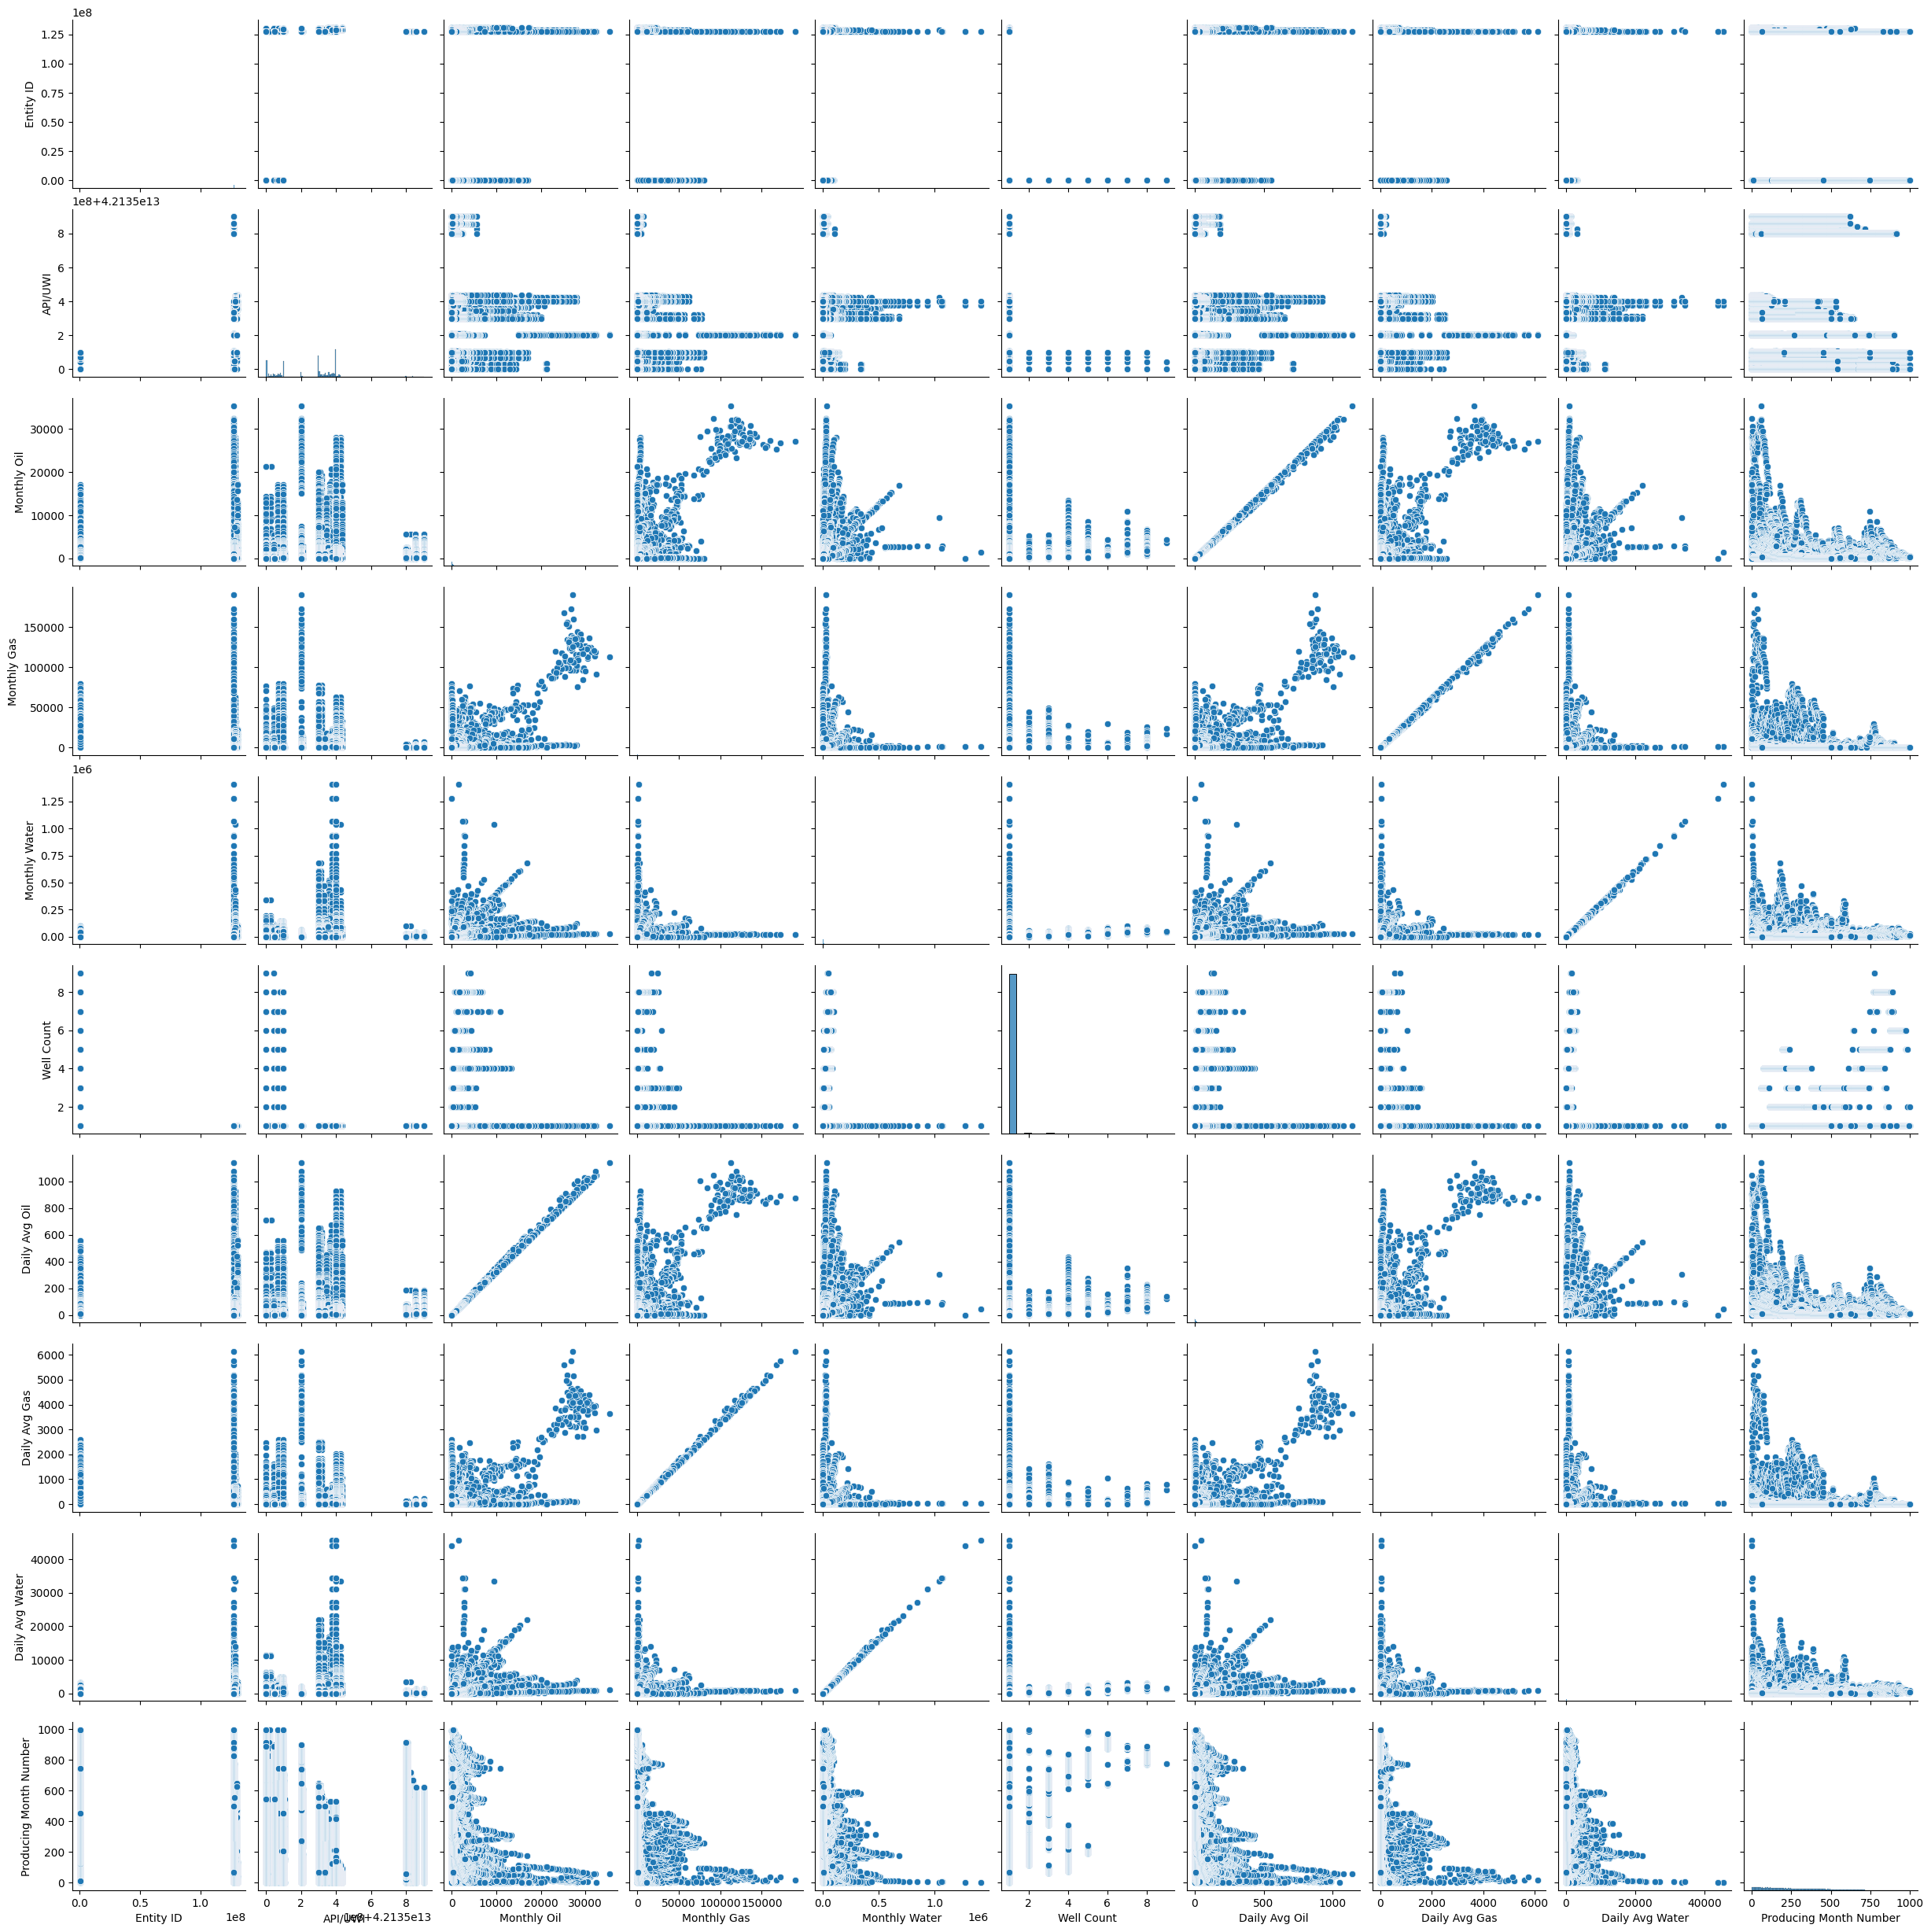

In [14]:
# Create a Pairplot for any correlations

sns.pairplot(df)

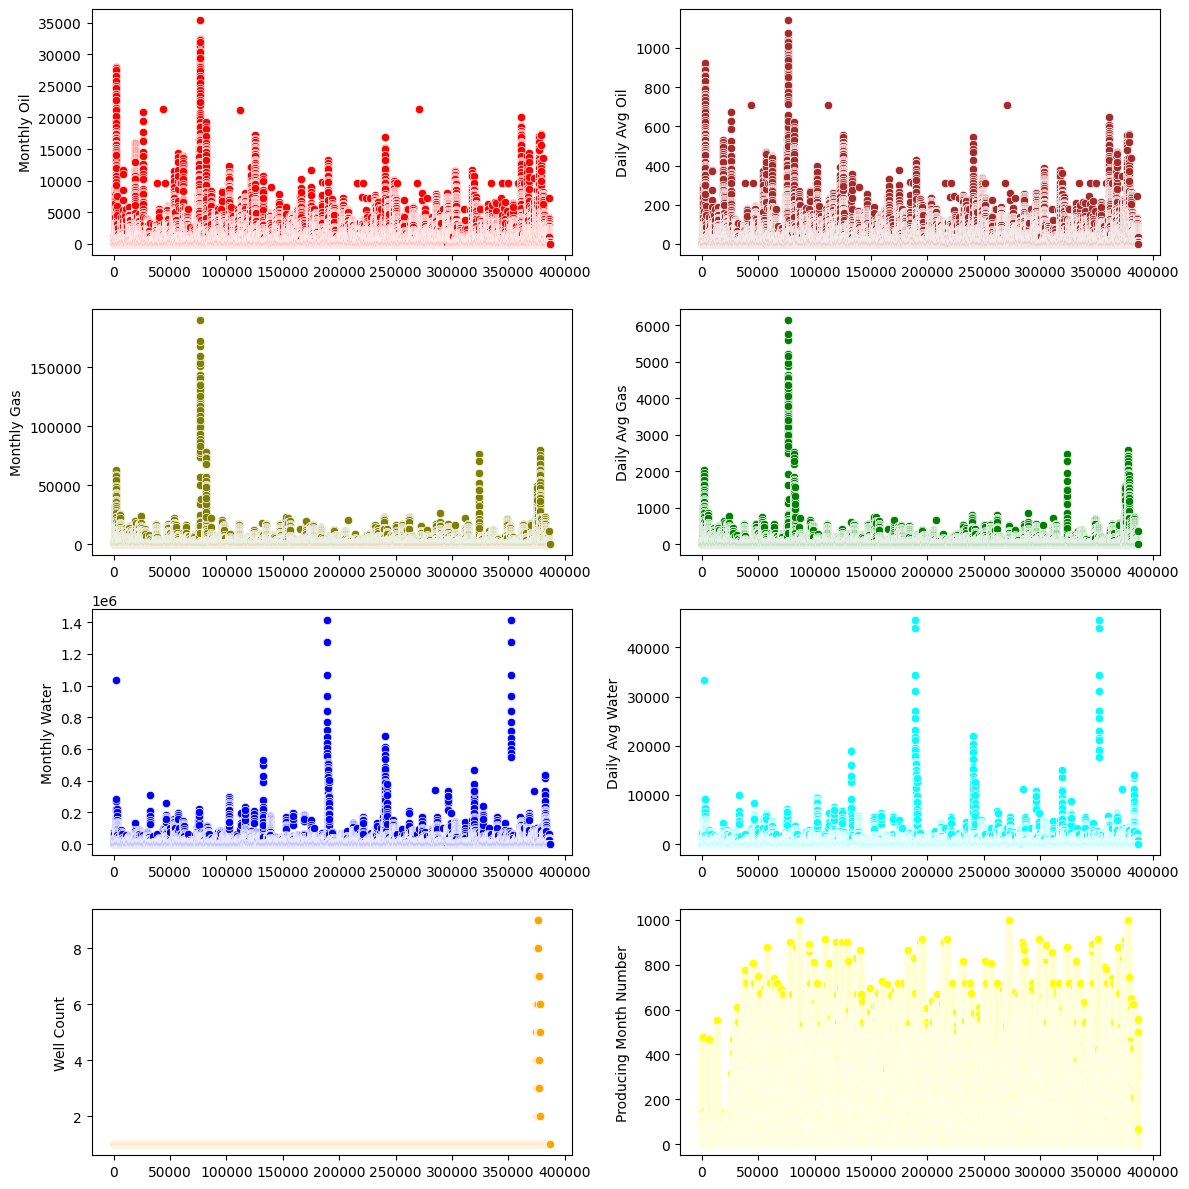

In [15]:
#let’s visualize the relations for each parameter

f, axes = plt.subplots(4, 2, figsize=(12, 12))
sns.scatterplot(df['Monthly Oil'] , color="red", ax=axes[0, 0])
sns.scatterplot(df['Daily Avg Oil'] , color="brown", ax=axes[0, 1])
sns.scatterplot(df['Monthly Gas'] , color="olive", ax=axes[1, 0])
sns.scatterplot(df['Daily Avg Gas'] , color="green", ax=axes[1, 1])
sns.scatterplot(df['Monthly Water'] , color="blue", ax=axes[2, 0])
sns.scatterplot(df['Daily Avg Water'] , color="cyan", ax=axes[2, 1])
sns.scatterplot(df['Well Count'] , color="orange", ax=axes[3, 0])
sns.scatterplot(df['Producing Month Number'] , color="yellow", ax=axes[3, 1])

plt.tight_layout()

<Axes: >

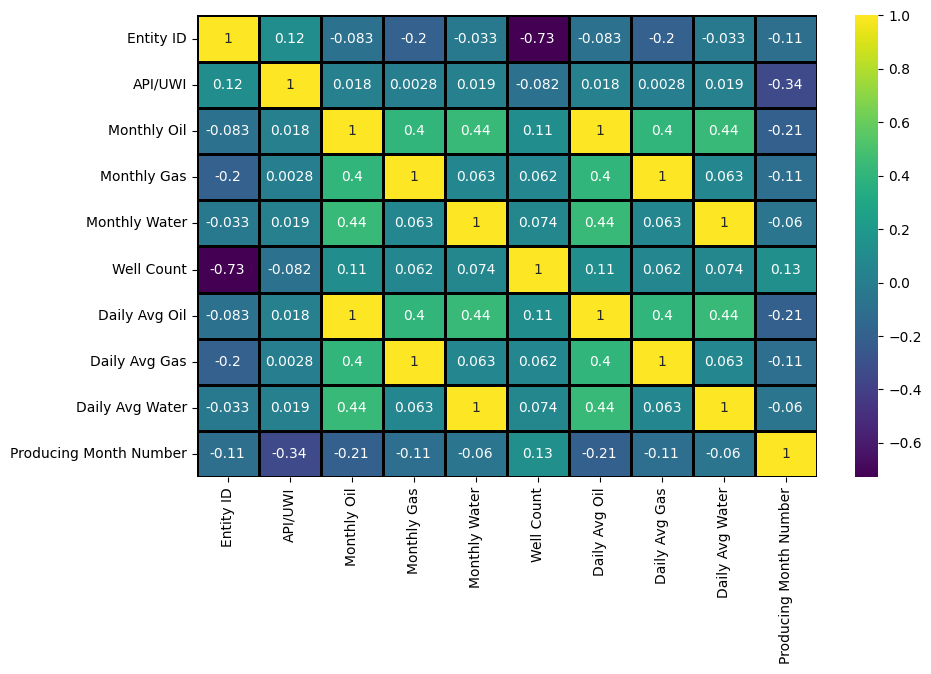

In [19]:
# Lets find any collinearity between input features using seaborn library

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),linewidths=2, linecolor='black',cmap='viridis', annot=True)

In [17]:
# calculate the correlation coefficients with the target variable

corr_matrix = df.corr(method='pearson')['Monthly Oil'].abs().sort_values(ascending=False)
corr_matrix

Monthly Oil               1.000000
Daily Avg Oil             0.999562
Monthly Water             0.439146
Daily Avg Water           0.438693
Monthly Gas               0.401042
Daily Avg Gas             0.400939
Producing Month Number    0.206470
Well Count                0.108853
Entity ID                 0.083361
API/UWI                   0.018353
Name: Monthly Oil, dtype: float64